## LMAPR1492 : Tâche 7

In [56]:
#Garção Antonio 
#33672100
#23/02/2024
# Modules nécessaires à importer
import numpy as np
from mp_api.client import MPRester
from matplotlib import pyplot as plt 
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from pymatgen.electronic_structure import plotter as SuperPlotter
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [57]:
# mp_key et mp_id du matériau 
mp_key = "zWerxXVKJ4OBcYhUP0oO4SXcDOfS6EVF"
mp_id = "mp-1960"

In [58]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()
print("Le recueil d'informations s'est bien déroulé")

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Le recueil d'informations s'est bien déroulé


### 1) Bande interdite

La bande interdite a une largeur de :  4.8986
Voici sa représentation (en violet) sur le graphe des vecteurs d'onde
J'ai la même valeur que sur material project
Comme la largeur de bande a une valeur supérieur à 2 eV, notre matériau est isolant


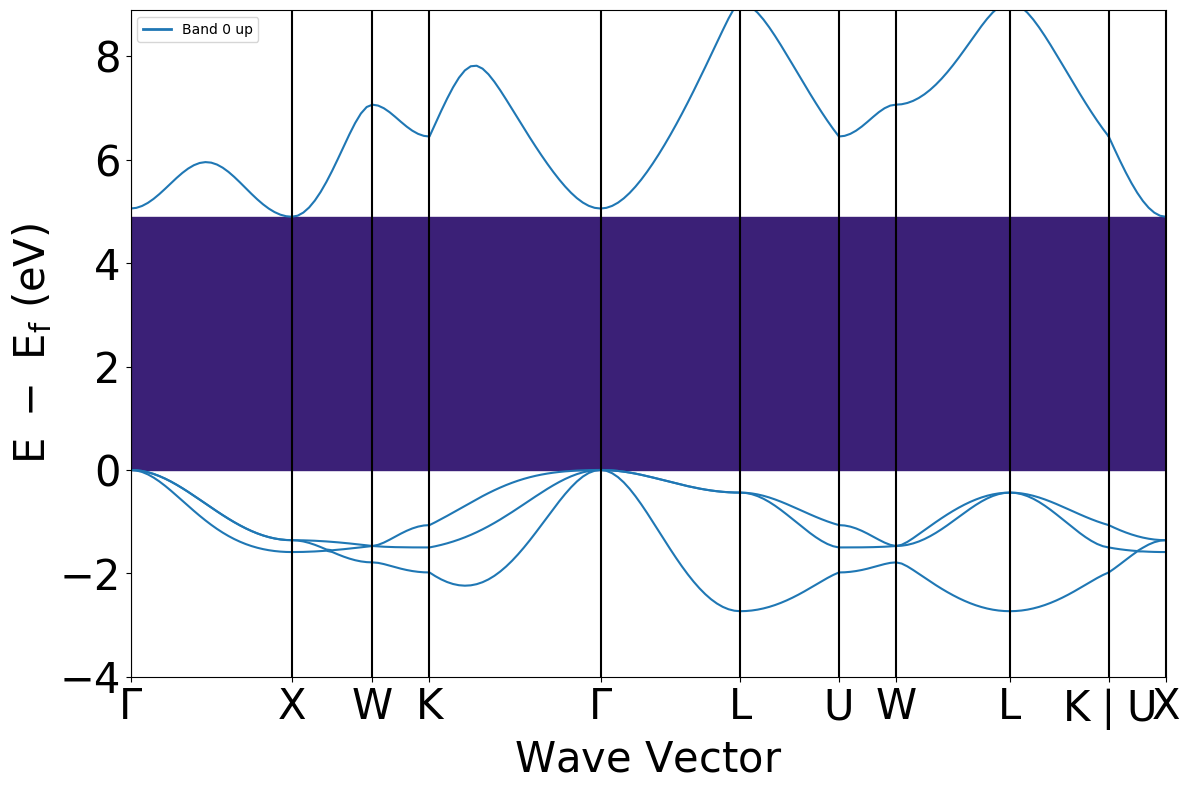

In [17]:
# J'affiche la valeur de la largeur de la bande interdite en eV
largeur_B_I = el_bs.get_band_gap()["energy"]
print("La bande interdite a une largeur de : ", largeur_B_I)
print("Voici sa représentation (en violet) sur le graphe des vecteurs d'onde")
# Je définis les variables et les paramètres nécessaires à afficher le graphe des vecteurs d'onde
plot = SuperPlotter.BSPlotter(el_bs)
d_t = plot.bs_plot_data()
#zero_energy = plot.bs_plot_data().get('zero_energy')
distance = plot.bs_plot_data().get('ticks').get('distance')
#labels = plot.bs_plot_data().get('ticks').get('label')
dists = d_t.get('distances')
#energy = data.get('energy')
#bandgap = el_bs.get_band_gap()
#vbmData = el_bs.get_vbm()
#cbmData = el_bs.get_cbm()
#J'affiche les vecteurs d'onde
plot.get_plot()
#J'affiche la band interdite
def_bande_interdite = plt.fill_between(np.linspace(distance[0],distance[-1],500),0,bandgap.get('energy'),color="#3B2077")

#cbms = data.get('cbm')
print("J'ai la même valeur que sur material project")
print("Comme la largeur de bande a une valeur supérieur à 2 eV, notre matériau est isolant")


### 2) Dispersion

Mon objectif maintenant est d'identifier les orientations où les bandes de valence et de conduction montrent la plus forte et la plus faible dispersion. Il est bon de se rappeler que la dispersion, à un point spécifique et dans une direction spécifique, est représentée par le taux de changement de l'énergie E par rapport au vecteur d'onde k, exprimé comme dE/dK. Lorsqu'on examine une direction spécifique, cette définition devient un peu plus complexe. Ce qui nous intéresse principalement, c'est de mesurer la dispersion comme le rapport entre la "quantité" d'états énergétiques disponibles et la "quantité" de vecteurs d'onde k, soit delta E par delta k. Cette approche est cohérente avec la définition au niveau d'un point. Ainsi, l'orientation qui montre la plus grande (ou la plus petite) dispersion est celle dont la bande d'énergie autorisée est la plus large (ou la plus étroite) le long de cette direction, en prenant soin de le normaliser par le nombre de vecteurs d'onde autorisés dans cette orientation (c'est-à-dire, la largeur de la bande le long de l'axe x).

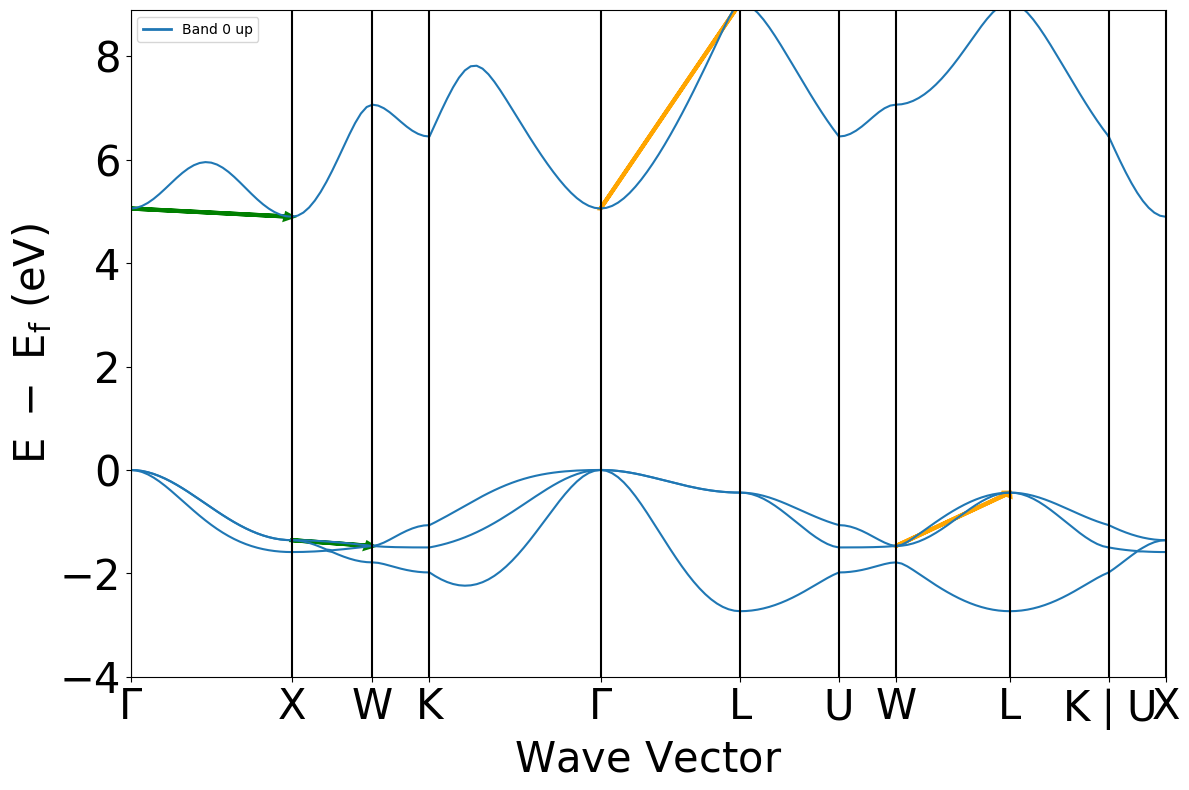

In [59]:
def tracer_dispersion(bandes):
    donnees = BSPlotter(bandes).bs_plot_data() # Extraction des données pour le tracé
    energie = donnees.get('energy').get('1')
    indice_vbm = list(bandes.get_vbm()['band_index'].values())[0][-1] # Index de la bande de valence avec l'énergie maximale
    indice_cbm = list(bandes.get_cbm()['band_index'].values())[0][0]  # Index de la bande de conduction avec l'énergie minimale
    points_x = np.unique(np.array(donnees.get('ticks').get('distance'))) # Points sur l'axe des x (points dans la zone de Brillouin)
    delta_k = points_x[1:] - points_x[:-1] # Pas delta k pour chaque direction
    dispersion_valence = np.empty(len(delta_k))    # Dispersion de la bande de valence
    dispersion_conduction = np.empty(len(delta_k)) # Dispersion de la bande de conduction
    for i in range(len(delta_k)):
        # Calcul de la dispersion (la différence max-min représente la largeur de bande des énergies permises)
        dispersion_valence[i] = (max(energie[i][indice_vbm]) - min(energie[i][indice_vbm]))/delta_k[i]
        dispersion_conduction[i] = (max(energie[i][indice_cbm]) - min(energie[i][indice_cbm]))/delta_k[i]
    # Indices de direction de dispersion min/max, pour les bandes de valence et de conduction
    indice_disp_min_val = np.argmin(dispersion_valence)
    indice_disp_max_val = np.argmax(dispersion_valence)
    indice_disp_min_cond = np.argmin(dispersion_conduction)
    indice_disp_max_cond = np.argmax(dispersion_conduction)
    # Tracé de la structure de bande
    graphique = BSPlotter(bandes).get_plot()
    # Tracé de la dispersion min/max pour les bandes de valence et de conduction (les flèches sont plus significatives si la relation de dispersion est monotone)
    plt.arrow(points_x[indice_disp_min_val], energie[indice_disp_min_val][indice_vbm][0], delta_k[indice_disp_min_val], energie[indice_disp_min_val][indice_vbm][-1]-energie[indice_disp_min_val][indice_vbm][0], head_width=0.10, head_length=0.05, linewidth=3, color='g', length_includes_head=True)
    plt.arrow(points_x[indice_disp_max_val], energie[indice_disp_max_val][indice_vbm][0], delta_k[indice_disp_max_val], energie[indice_disp_max_val][indice_vbm][-1]-energie[indice_disp_max_val][indice_vbm][0], head_width=0.10, head_length=0.05, linewidth=3, color='orange', length_includes_head=True)
    plt.arrow(points_x[indice_disp_min_cond], energie[indice_disp_min_cond][indice_cbm][0], delta_k[indice_disp_min_cond], energie[indice_disp_min_cond][indice_cbm][-1]-energie[indice_disp_min_cond][indice_cbm][0], head_width=0.10, head_length=0.05, linewidth=3, color='g', length_includes_head=True)
    plt.arrow(points_x[indice_disp_max_cond], energie[indice_disp_max_cond][indice_cbm][0], delta_k[indice_disp_max_cond], energie[indice_disp_max_cond][indice_cbm][-1]-energie[indice_disp_max_cond][indice_cbm][0], head_width=0.10, head_length=0.05, linewidth=3, color='orange', length_includes_head=True)
    # Affichage de la structure de bande
    plt.show()

plot_dispersion(el_bs)

### 3) Masse effective

Pour résoudre ce problème, je fixe quelques points:
- La dispersion est parabobolique.
- Je fais une interpolation linéaire d'ordre 2.
- Avoir les bonnes unités. 
- E(k) est l'énergie d'un électron de vecteur d'onde k dans la bande fixée.

On a donc comme formules :
$$\frac{1}{m_*} = \frac{1}{\hbar^2}\frac{\mathrm ∂^2}{\mathrm ∂k^2} \left( E \right)$$
D'où on tire cette expression :
$$m_* = \frac{\hbar^2}{\frac{\mathrm ∂^2}{\mathrm ∂ k^2} \left( E \right)}$$

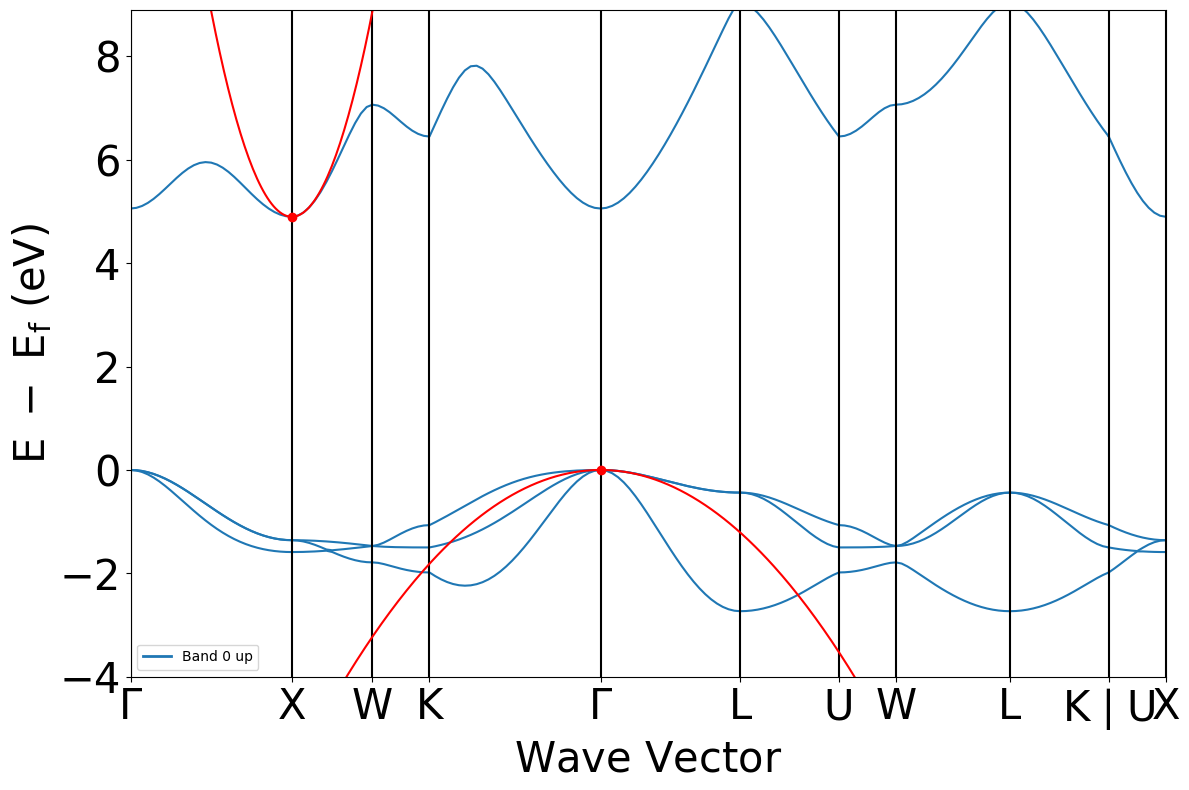

La masse effective au sommet de la bande de valence est de -3.922682764423652e-30 kg.
La masse effective au bas de la bande de conduction est de 1.640512884927829e-33 kg.


In [60]:
#J'écris mon code en deux fonctions pour trouver les masses et pour afficher le graphe des vecteurs d'onde avec les paraboles
def eval_effective_mass(band_structure, show_details=False):
    
    #Calcule la masse effective en utilisant la structure de bande donnée.
    
  
    # Extraction des données nécessaires à partir de la structure de bande
    plot_data = BSPlotter(band_structure).bs_plot_data()
    energy_levels = plot_data.get('energy').get('1')
    
    # Indices pour la bande de valence et de conduction
    vbm_idx = list(band_structure.get_vbm()['band_index'].values())[0][-1]
    cbm_idx = list(band_structure.get_cbm()['band_index'].values())[0][0]
    
    # Extraction des distances, servant d'indices sur l'axe des abscisses
    distance_points = plot_data.get('distances')
    
    # Calcul de la dérivée seconde de l'énergie par rapport à k pour la bande de valence
    delta_E_v = 2 * energy_levels[4][vbm_idx][1] * (1.602176634e-39 / ((distance_points[4][1] - distance_points[4][0]) ** 2))
    eff_mass_v = (6.626e-34 / (2 * np.pi)) ** 2 / delta_E_v  # Masse effective de la bande de valence
    
    # Idem pour la bande de conduction
    delta_E_c = 2 * energy_levels[1][cbm_idx][1] * (1.602176634e-39 / ((distance_points[1][1] - distance_points[1][0]) ** 2))
    eff_mass_c = (6.626e-34 / (2 * np.pi)) ** 2 / delta_E_c  # Masse effective de la bande de conduction
    
    # Affichage des détails si demandé
    if show_details:
        plot_valence_and_conduction_bands(energy_levels, vbm_idx, cbm_idx, distance_points, band_structure, eff_mass_v, eff_mass_c)
    # return: Tuple contenant la masse effective pour la bande de valence et la bande de conduction.
    return eff_mass_v, eff_mass_c

def plot_valence_and_conduction_bands(energy_levels, vbm_idx, cbm_idx, distance_points, band_structure, eff_mass_v, eff_mass_c):
    """
    Fonction pour tracer les bandes de valence et de conduction, ainsi que calculer et afficher les masses effectives.
    
    :param energy_levels: Niveaux d'énergie extraits de la structure de bande.
    :param vbm_idx: Indice du maximum de la bande de valence.
    :param cbm_idx: Indice du minimum de la bande de conduction.
    :param distance_points: Points de distance pour les calculs.
    :param band_structure: Structure de bande pour obtenir le graphe.
    :param eff_mass_v: Masse effective de la bande de valence.
    :param eff_mass_c: Masse effective de la bande de conduction.
    """
    v_x_points = [2 * distance_points[4][0] - distance_points[4][1], distance_points[4][0], distance_points[4][1]]
    v_y_points = [energy_levels[4][vbm_idx][1], energy_levels[4][vbm_idx][0], energy_levels[4][vbm_idx][1]]
    
    c_x_points = [2 * distance_points[1][0] - distance_points[1][1], distance_points[1][0], distance_points[1][1]]
    c_y_points = [energy_levels[1][cbm_idx][1], energy_levels[1][cbm_idx][0], energy_levels[1][cbm_idx][1]]
    
    band_gap_energy = band_structure.get_band_gap()["energy"]
    
    # Préparation du tracé
    x_range = np.linspace(distance_points[0][0], distance_points[-1][-1], 500)
    plot = BSPlotter(band_structure).get_plot()
    
    # Tracé des points max/min des bandes de valence/conduction
    plt.plot([distance_points[4][0], distance_points[1][0]], [0, band_gap_energy], 'o', color='red')
    
    # Tracé des paraboles pour les hypothèses de dispersion parabolique
    plt.plot(x_range, np.polyval(np.polyfit(v_x_points, v_y_points, 2), x_range), 'red')
    plt.plot(x_range, np.polyval(np.polyfit(c_x_points, c_y_points, 2), x_range), 'red')
    
    plt.show()
    print(f"La masse effective au sommet de la bande de valence est de {eff_mass_v} kg.\nLa masse effective au bas de la bande de conduction est de {eff_mass_c} kg.")

# Appel de la fonction avec l'objet band_structure (remplacer `el_bs` par l'objet correspondant)
valence_mass, conduction_mass = eval_effective_mass(el_bs, show_details=True)
